### Setup

In [26]:
import importlib.util
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 

base_path = 'D:\\Projekte\\MSE\\MSE_SimCLR\\'
folder_name = base_path + 'runs\\Apr02_21-57-29_LAPTOP-T1N7HK2E'
output_dimension = 512
batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_folder = os.path.join(folder_name, 'model')

### Load Images from folder

In [27]:
# Source: https://github.com/mttk/STL10/blob/master/stl10_input.py
def load_images(set):
    X = np.fromfile(base_path + '\\data\\stl10_binary\\' + set + '_X.bin', dtype=np.uint8)
    y = np.fromfile(base_path + '\\data\\stl10_binary\\' + set + '_y.bin', dtype=np.uint8)
    y = y - 1 #scale from 0-9 instead of 1-10
    X = np.reshape(X, (-1, 3, 96, 96))
    X = np.transpose(X, (0, 1, 3, 2))

    return X, y

# restore images
X_train, y_train = load_images("train")
X_test, y_test = load_images("test")



### Functions for evaluation

In [28]:
def exec_logistic_regression(X_train, y_train, X_test, y_test):
    logistic_regression = LogisticRegression(random_state=0, max_iter=10000, solver='lbfgs', C=1.0)
    logistic_regression.fit(X_train, y_train)
    return logistic_regression.score(X_train, y_train), logistic_regression.score(X_test, y_test)

def exec_k_nearest_neighbors(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)
    return knn.score(X_train, y_train), knn.score(X_test, y_test)

### Test with extracted features from PCA

To see how good the self implemented SimCLR works, we compare it with PCA as a feature extractor.

> Principle Component Analysis (PCA) is a common feature extraction method in data science. Technically, PCA finds the eigenvectors of a covariance matrix with the highest eigenvalues and then uses those to project the data into a new subspace of equal or less dimensions. Practically, PCA converts a matrix of `n` features into a new dataset of (hopefully) less than `n` features. That is, it reduces the number of features by constructing a new, smaller number variables which capture a signficant portion of the information found in the original features. However, the goal of this tutorial is not to explain the concept of PCA, that is done very well elsewhere, but rather to demonstrate PCA in action.

_Source:_ [https://chrisalbon.com/machine_learning/feature_engineering/feature_extraction_with_pca/](https://chrisalbon.com/machine_learning/feature_engineering/feature_extraction_with_pca/)

In [29]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=output_dimension)
X_train_pca = pca.fit_transform(standard_scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(standard_scaler.transform(X_test.reshape(X_test.shape[0], -1)))

reg_train_score_pca, reg_test_score_pca = exec_logistic_regression(X_train_pca, y_train, X_test_pca, y_test)
knn_train_score_pca, knn_test_score_pca = exec_k_nearest_neighbors(X_train_pca, y_train, X_test_pca, y_test)

### Test with trained model

#### Setup

In [30]:
spec = importlib.util.spec_from_file_location("model", os.path.join(base_path, 'resnet_model.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

model = resnet_module.ResNetModel(output_dimension)
model.eval()
state_dict = torch.load(os.path.join(model_folder, 'res_net.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)
        
def next_batch(X):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        yield X_batch.to(device)

#### Train

In [31]:
X_train_feature = []
X_test_feature = []

for x in next_batch(X_train):
    features, _ = model(x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
for x in next_batch(X_test):
    features, _ = model(x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)
X_test_feature = np.array(X_test_feature)


#### Test

In [32]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train_feature)

reg_train_score_mod, reg_test_score_mod = exec_logistic_regression(standard_scaler.transform(X_train_feature), y_train, standard_scaler.transform(X_test_feature), y_test)
knn_train_score_mod, knn_test_score_mod = exec_k_nearest_neighbors(standard_scaler.transform(X_train_feature), y_train, standard_scaler.transform(X_test_feature), y_test)

## Plot result

We compare the self implemented SimCLR with PCA as feature extractor. Therefore, we use the training and test images from the STL-10 dataset.


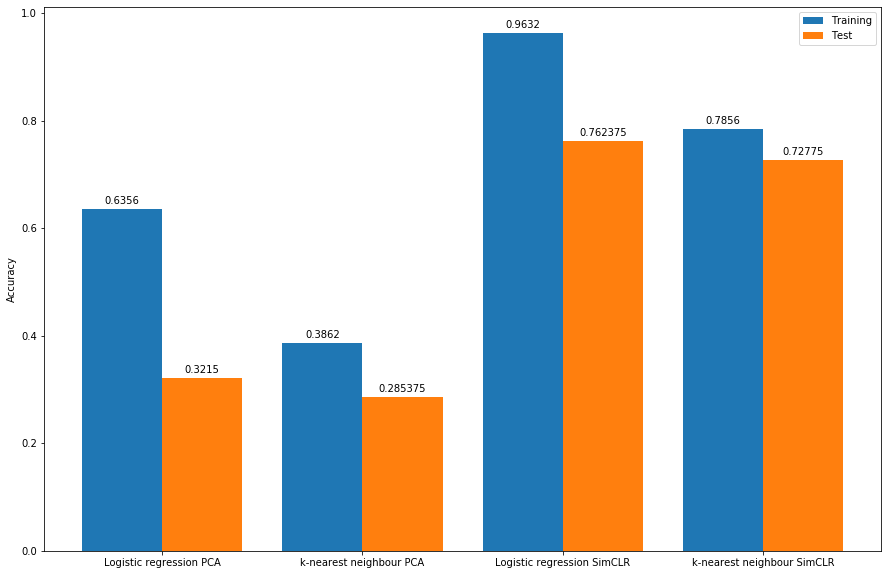

In [33]:
labels = ['Logistic regression PCA', 'k-nearest neighbour PCA', 'Logistic regression SimCLR', 'k-nearest neighbour SimCLR']
train = [reg_train_score_pca, knn_train_score_pca, reg_train_score_mod, knn_train_score_mod]
test = [reg_test_score_pca, knn_test_score_pca, reg_test_score_mod, knn_test_score_mod]

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train, width, label='Training')
rects2 = ax.bar(x + width/2, test, width, label='Test')

ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

Comparison of SimCLR with PCA: Therefore, visual representations are extracted, once with PCA and once with SimCLR. Then
these visual representations are used to classify images with a logistic regression and a k-nearest neighbour classifier.

## Observations
- The model trained according to the SimCLR framework provides better results than PCA. 
- The relatively large gap between PCA and SimCLR indicates that SimCLR is a promising approach
- Logistic regression achieves a better result than k-nearest neighbour for both, PCA and SimCLR
- The gap between training and test accuracy is much larger for logistic regression than for KNN
  - Suggestion: Logistic regression is "trained" on the training data which leads to a better training result


#### 76% accuracy - better than the original?

No! It is true that the model in the original paper only achieves an accuracy of 57.5% with 100 epochs and a batch size of 256.
But they trained on ImageNet which is a database with almost 20'000 categories. STL-10 has only 10 categories.
The appendix of the paper also describes that they have trained their model on CIFAR-10, another dataset with only 10 categories.
With a batch size of 2048 and 1000 epochs they have achieved an accuracy of over 94%.